## DataLoader
- [param] read dataset list, list of jpg
    -  assume has corresponding xml file beside
- [param] .name file for label hashing
- read bbbox data
- build dict [image path: annotation]


### Import

In [1]:
# !pip3 install easydict
# !pip3 install fire

In [2]:
# export
import random
import cv2
import sys
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# export
from torch.utils.data.dataset import Dataset
from exp.voc_io import *

In [4]:
from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 10)

## Functions


In [5]:
# export
from exp.nb_RandomHelper import rand_uniform_strong, rand_scale

In [6]:
# export
def show(path):### Pytorch Dataset

    img = cv2.imread(path)
    imshow(img)

### Augmentation


In [7]:
# export
def fill_truth_detection(bboxes, num_boxes, classes, flip, dx, dy, sx, sy, net_w, net_h):
    if bboxes.shape[0] == 0:
        return [], 10000
    
    bboxes[:,[0,2]] -= dx
    bboxes[:,[1,3]] -= dy
    
#     ## remove boxes which center is outside 
#     center = bboxes[:,[0,1]] + (bboxes[:,[2,3]] - bboxes[:,[0,1]] / 2)
#     keep_indexes = np.logical_and(center >= [0,0], center <= [sx,sy]).all(1)
#     bboxes = bboxes[keep_indexes]
    
#     if bboxes.shape[0] == 0:
#         return [], 10000

    ## remove invalid classes
    bboxes = bboxes[np.logical_and(bboxes[:,4] >= 0, bboxes[:,4] < classes)]

    ## Apply Scale
    bboxes[:, 0:4] *= [net_w / sx, net_h / sy, net_w / sx, net_h / sy]
    
    ## Remove extra small boxes
    min_sizes = (bboxes[:,[2,3]]- bboxes[:,[0,1]]).min(1)
#     indexes = min_sizes > 20
#     bboxes = bboxes[indexes]
#     min_sizes = min_sizes[indexes]
    
#     if bboxes.shape[0] == 0:
#         return [], 10000
    
    min_w_h = min_sizes.min()

    if flip:
        bboxes[:, [2,0]] = net_w - bboxes[:, [0,2]]
    
    return bboxes, min_w_h

def rect_intersection(a, b):
    minx = max(a[0], b[0])
    miny = max(a[1], b[1])

    maxx = min(a[2], b[2])
    maxy = min(a[3], b[3])
    return [minx, miny, maxx, maxy]

def image_data_augmentation(mat, w, h, pleft, ptop, swidth, sheight, flip, dhue, dsat, dexp, gaussian_noise, blur,
                            truth):
    try:
        img = mat
        oh, ow, _ = img.shape
        pleft, ptop, swidth, sheight = int(pleft), int(ptop), int(swidth), int(sheight)
        # crop
        src_rect = [pleft, ptop, swidth + pleft, sheight + ptop]  # x1,y1,x2,y2
        img_rect = [0, 0, ow, oh]
        new_src_rect = rect_intersection(src_rect, img_rect)  # 交集

        dst_rect = [max(0, -pleft), max(0, -ptop), max(0, -pleft) + new_src_rect[2] - new_src_rect[0],
                    max(0, -ptop) + new_src_rect[3] - new_src_rect[1]]
        # cv2.Mat sized

        if (src_rect[0] == 0 and src_rect[1] == 0 and src_rect[2] == img.shape[0] and src_rect[3] == img.shape[1]):
            sized = cv2.resize(img, (w, h), cv2.INTER_LINEAR)
        else:
            cropped = np.zeros([sheight, swidth, 3])
            cropped[:, :, ] = np.mean(img, axis=(0, 1))

            cropped[dst_rect[1]:dst_rect[3], dst_rect[0]:dst_rect[2]] = \
                img[new_src_rect[1]:new_src_rect[3], new_src_rect[0]:new_src_rect[2]]

            # resize
            sized = cv2.resize(cropped, (w, h), cv2.INTER_LINEAR)

        # flip
        if flip:
            # cv2.Mat cropped
            sized = cv2.flip(sized, 1)  # 0 - x-axis, 1 - y-axis, -1 - both axes (x & y)

        # HSV augmentation
        # cv2.COLOR_BGR2HSV, cv2.COLOR_RGB2HSV, cv2.COLOR_HSV2BGR, cv2.COLOR_HSV2RGB
        if dsat != 1 or dexp != 1 or dhue != 0:
            if img.shape[2] >= 3:
                hsv_src = cv2.cvtColor(sized.astype(np.float32), cv2.COLOR_RGB2HSV)  # RGB to HSV
                hsv = cv2.split(hsv_src)
                hsv[1] *= dsat
                hsv[2] *= dexp
                hsv[0] += 179 * dhue
                hsv_src = cv2.merge(hsv)
                sized = np.clip(cv2.cvtColor(hsv_src, cv2.COLOR_HSV2RGB), 0, 255)  # HSV to RGB (the same as previous)
            else:
                sized *= dexp

        if blur:
            if blur == -1:
                ## Apply blur with kernal 17
                dst = cv2.GaussianBlur(sized, (17, 17), 0)
                # cv2.bilateralFilter(sized, dst, 17, 75, 75)
                
                ## Copy Object from before blur
                sized_h,sized_w,_ = sized.shape
                for b in truth:
                    print(b)
                    left = (b.x - b.w / 2.) * sized_h
                    width = b.w * sized_h
                    top = (b.y - b.h / 2.) * sized_w
                    height = b.h * sized_w
                    
                    x1,x2 = max(int(left),0), min(int(left + width), sized_w)
                    y1,y2 = max(int(top),0), min(int(top + height), sized_h)
                    dst[x1:x2, y1:y2] = sized[x1:x2, y1:y2]

            else:
                ksize = (blur//2) * 2 + 1 # 2->3, 3->3, 4->5
                dst = cv2.GaussianBlur(sized, (ksize, ksize), 0)
            sized = dst

        if gaussian_noise:
            noise = np.array(sized.shape)
            gaussian_noise = max(0, min(gaussian_noise, 127))  # range ~ [0,127]
            cv2.randn(noise, 0, gaussian_noise)  # mean and variance
            sized = np.clip(sized + nois, 0, 255)
    except Exception as e:
        print("OpenCV can't augment image: " + str(w) + " x " + str(h))
        print(e)
        sized = mat

    return sized


In [8]:
# export
def filter_truth(bboxes, dx, dy, sx, sy, xd, yd):
    if len(bboxes) == 0:
        return bboxes
        
    bboxes[:,[0,2]] -= dx
    bboxes[:,[1,3]] -= dy
    
    ## remove boxes which center is outside 
    center = bboxes[:,[0,1]] + ((bboxes[:,[2,3]] - bboxes[:,[0,1]]) / 2)
    keep_indexes = np.logical_and(center >= [0,0], center <= [sx,sy]).all(1)
    bboxes = bboxes[keep_indexes]
    
    bboxes[:, [0,2]] = np.clip(bboxes[:, [0,2]], 0, sx)
    bboxes[:, [1,3]] = np.clip(bboxes[:, [1,3]], 0, sy)    
    
    bboxes[:,[0,2]] += xd
    bboxes[:,[1,3]] += yd
    
    return bboxes


In [9]:
# export
def blend_truth_mosaic(out_img, img, bboxes, w, h, cut_x, cut_y, i_mixup,
                       left_shift, right_shift, top_shift, bot_shift):
    
    
    left_shift = min(left_shift, w - cut_x)
    top_shift = min(top_shift, h - cut_y)
    right_shift = min(right_shift, cut_x)
    bot_shift = min(bot_shift, cut_y)
    
    if i_mixup == 0:
        bboxes = filter_truth(bboxes, left_shift, top_shift, cut_x, cut_y, 0, 0)
        out_img[:cut_y, :cut_x] = img[top_shift:top_shift + cut_y, left_shift:left_shift + cut_x]
    if i_mixup == 1:
        bboxes = filter_truth(bboxes, cut_x - right_shift, top_shift, w - cut_x, cut_y, cut_x, 0)
        out_img[:cut_y, cut_x:] = img[top_shift:top_shift + cut_y, cut_x - right_shift:w - right_shift]
    if i_mixup == 2:
        bboxes = filter_truth(bboxes, left_shift, cut_y - bot_shift, cut_x, h - cut_y, 0, cut_y)
        out_img[cut_y:, :cut_x] = img[cut_y - bot_shift:h - bot_shift, left_shift:left_shift + cut_x]
    if i_mixup == 3:
        bboxes = filter_truth(bboxes, cut_x - right_shift, cut_y - bot_shift, w - cut_x, h - cut_y, cut_x, cut_y)
        out_img[cut_y:, cut_x:] = img[cut_y - bot_shift:h - bot_shift, cut_x - right_shift:w - right_shift]

    return out_img, bboxes


In [10]:
# export
def resize_gt(gt, srcSize=(1000,1000), targetSize = (416,416)):
    ratio_h = targetSize[0] / srcSize[0]
    ratio_w = targetSize[1] / srcSize[1]
    
    gt = gt * [ratio_w, ratio_h, ratio_w, ratio_h, 1]
    
    return gt

### Pytorch Dataset

In [32]:
# export
class Detection_dataset(Dataset):
    def __init__(self, image_paths, cfg=None, val=False, val_keep_size=False):
        super(Detection_dataset, self).__init__()
        
        self.val_mode = val
        self.val_keep_size = val_keep_size
        self.cfg = cfg
        
        names = ["palm1_npt"] ##, "palm1_byt", "palm2_mtl"]
        self.names = {name:i for i,name in enumerate(names)}
        
        self.names["palm1-npt"] = 0
        
        self.id_names = {i: name for i,name in enumerate(names)}
        
        truth = {}
        f = open(image_paths, 'r', encoding='utf-8')
        for line in f.readlines():
            path = line.rstrip()
            truth[path] = self.read_annot(path)         
        self.truth = truth
        
    def read_annot(self, jpg):
        parts = jpg.split('.')
        parts[-1] = 'xml'
        xml = '.'.join(parts)
        
        annots = PascalVocReader(xml).getAnnot()
        for annot in annots:
            uid = self.names.get(annot[-1], None)
            if uid == None:
                uid = self.extend_name(annot[-1])
            annot[-1] = uid
        return annots
        
    def extend_name(self, name):
        newId = len(self.names.keys())
        self.names[name] = newId
        self.id_names[newId] = name
        print("Added Missing Name: %d, %s"%(newId, name))
        return newId
        
    def __getitem__(self, index):
        
        ## Setup
        mosaic = True
        # w, h = self.cfg.w, self.cfg.h
        w, h = 416,416                
        
        r1, r2, r3, r4, r_scale = 0, 0, 0, 0, 0
        dhue, dsat, dexp, flip, blur = 0, 0, 0, 0, 0
        gaussian_noise = 0
        
        out_img = np.zeros([h, w, 3])
        out_bboxes = []
        
        ## augmentation
        if mosaic and not self.val_mode: 
            min_offset = 0.2
            max_offset = 1 - min_offset
            cut_x = random.randint(int(w * min_offset), int(w * max_offset))
            cut_y = random.randint(int(h * min_offset), int(h * max_offset))
            
            temp_out_bboxes = []
            for i in range(4):
                if i == 0:
                    img_path = list(self.truth.keys())[index]
                else:
                    img_path = random.choice(list(self.truth.keys()))
                    
                bboxes = np.array(self.truth.get(img_path), dtype=np.float)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if img is None:
                    continue
                    
                oh, ow, oc = img.shape
                dh, dw, dc = np.array(np.array([oh, ow, oc]) * self.cfg.jitter, dtype=np.int)
                dhue = rand_uniform_strong(-self.cfg.hue, self.cfg.hue)
                dsat = rand_scale(self.cfg.saturation)
                dexp = rand_scale(self.cfg.exposure)
                
                flip = random.randint(0, 1) if self.cfg.flip else 0
                
                if self.cfg.blur:
                    tmp_blur = random.randint(0, 2) 
                    if tmp_blur == 0:       # 0 - disable
                        blur = 0
                    elif tmp_blur == 1:     # -1 - blur background, 
                        blur = -1
                    else:                   # n ~ [2,n] - blur with config scale
                        blur = max(self.cfg.blur,2)
                        
                if self.cfg.gaussian:
                    gaussian_noise = random.randint(0, 1)
                
                pleft = random.randint(-dw, dw)
                ptop = random.randint(-dh, dh)
                
                pright = random.randint(-dw, dw)
                pbot = random.randint(-dh, dh)
                
                swidth = ow - pleft - pright
                sheight = oh - ptop - pbot
                
                aspect_ratio = True
                if aspect_ratio: ## maintain aspect-ratio:
                    if swidth > sheight :
                        pright = swidth - ow + pleft
                        swidth = sheight
                    else:
                        pbot = sheight - oh + ptop
                        sheight = swidth
                
                truth, min_w_h = fill_truth_detection(bboxes, self.cfg.boxes, self.cfg.classes, flip, pleft, ptop, swidth,
                                                  sheight, self.cfg.w, self.cfg.h)
                
                if blur>0: 
                    if min_w_h < 8:  # disable blur if one of the objects is too small
                        blur = 0
                    else:            # change blur factor according to the min_obj_size
                        blur = min(int(min_w_h / 8), blur)
                
                
                ai = image_data_augmentation(img, self.cfg.w, self.cfg.h, pleft, ptop, swidth, sheight, flip,
                                         dhue, dsat, dexp, gaussian_noise, blur, truth)
                
                if flip:
                    pleft, pright = pright, pleft

                left_shift = int(min(cut_x, max(0, (-int(pleft) * self.cfg.w / swidth))))
                top_shift = int(min(cut_y, max(0, (-int(ptop) * self.cfg.h / sheight))))

                right_shift = int(min((self.cfg.w - cut_x), max(0, (-int(pright) * self.cfg.w / swidth))))
                bot_shift = int(min(self.cfg.h - cut_y, max(0, (-int(pbot) * self.cfg.h / sheight))))

                out_img, out_bbox = blend_truth_mosaic(out_img, ai, truth.copy(), self.cfg.w, self.cfg.h, cut_x,
                                                       cut_y, i, left_shift, right_shift, top_shift, bot_shift)
                temp_out_bboxes.append(out_bbox)
                
            out_bboxes = [box for bboxes in temp_out_bboxes for box in bboxes]
        else:
            ## read image and Annot
            img_path = list(self.truth.keys())[index]
            img = cv2.imread(img_path)
            bboxes = np.array(self.truth.get(img_path), dtype=np.float)
            
            if not self.val_keep_size:
                img = cv2.resize(img, (w, h), cv2.INTER_LINEAR)
                bboxes = resize_gt(bboxes)
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            out_img = img
            out_bboxes = bboxes        
        
        ## return: img_tensor, annotation
        return out_img, out_bboxes
    
        
    def __len__(self):
        return len(self.truth.keys())
    
    def sample(self):
        
        for i in range(1,4):
            index = random.randint(0, len(self)-1)

            img_src, bboxes = self[index]
            img = np.array(img_src, dtype=np.uint8)

            size = min(img.shape[:2])
            border = max(size // 200 ,1)
            font_size = max(size // 500,1)

            for b in bboxes:
                b = list(map(int,b))
                cv2.rectangle(img, (b[0],b[1]), (b[2],b[3]), (0,0,255), border)
                text = self.id_names[b[4]]
                cv2.putText(img, text, (b[0],b[1]), cv2.FONT_HERSHEY_PLAIN, font_size, (255,0,0), border)

            plt.subplot(2,2,i)
            plt.tight_layout()
            plt.imshow(img)

## Usage

In [33]:
from config.config import Cfg

In [34]:
# data_list = "/Users/ckh/OneDrive - Default Directory/Hui_Wan/train.txt"
data_list = "/Users/ckh/OneDrive - Default Directory/Hui_Wan/val2_mac.txt"
dataset = Detection_dataset(data_list, Cfg)
dataset.names

{'palm1_npt': 0, 'palm1-npt': 0}

# Dataset : 54
Sample: 
/Users/ckh/OneDrive - Default Directory/Hui_Wan/Sample_Anno_Data_NPT/18_GSKE_Sungai_Pin_4_ytl_0007.JPG
Items: 
[[117, 135, 206, 224, 0], [305, 240, 391, 326, 0], [541, 71, 609, 138, 0], [764, 159, 825, 220, 0], [561, 294, 633, 366, 0], [743, 508, 826, 591, 0], [920, 313, 1000, 399, 0], [80, 447, 161, 528, 0], [370, 483, 463, 576, 0], [535, 625, 630, 720, 0], [584, 855, 670, 941, 0], [776, 772, 893, 889, 0], [107, 821, 184, 898, 0], [345, 774, 426, 856, 0]]


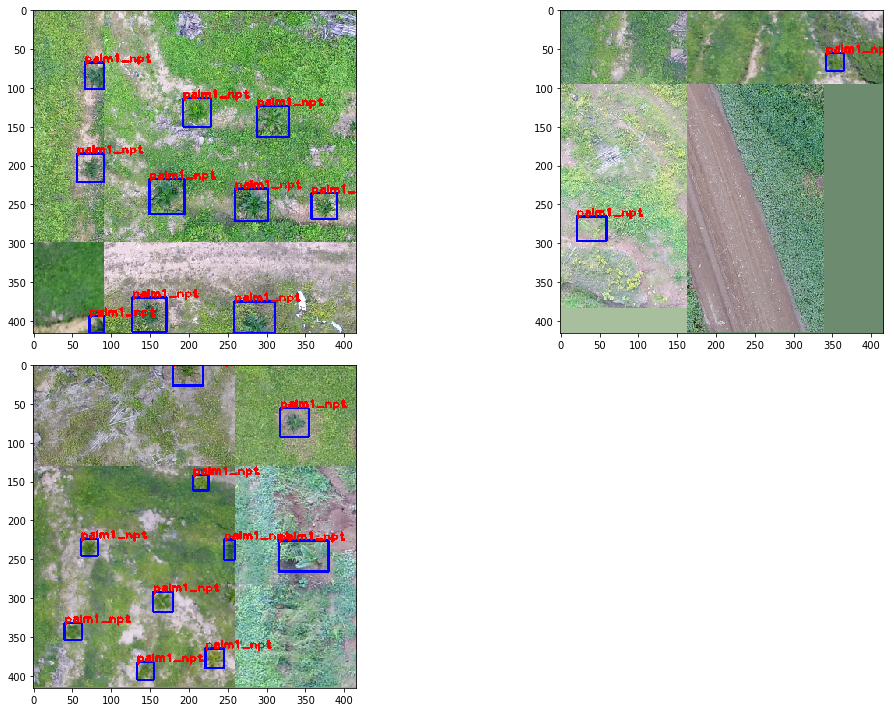

In [35]:
print("# Dataset :", len(dataset.truth))

print("Sample: ")
key = list(dataset.truth.keys())[0]
print(key)
print("Items: ")
print(dataset.truth[key])

dataset.sample()

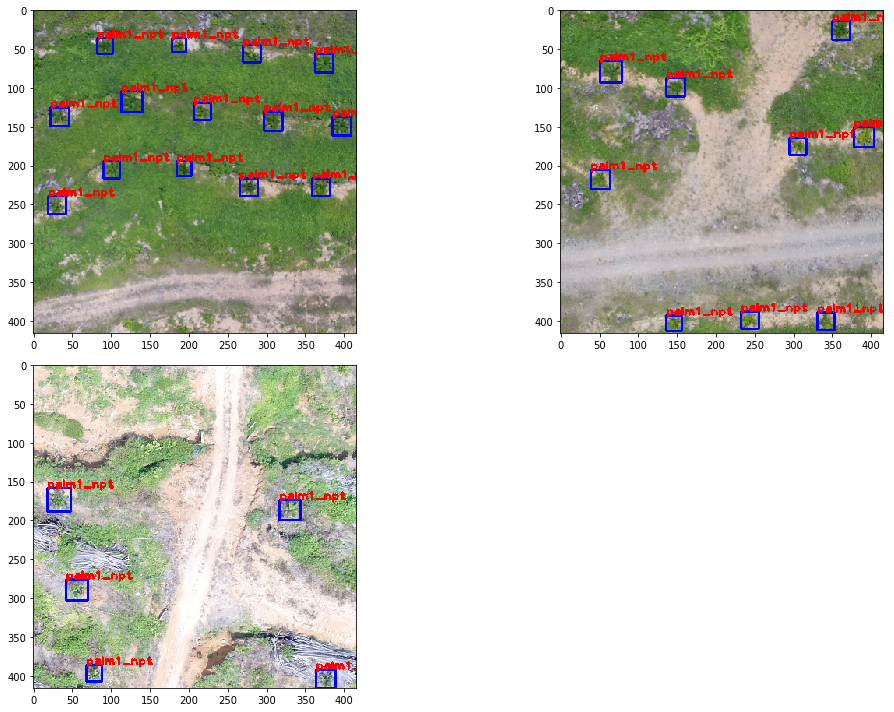

In [27]:
val_dataset = Detection_dataset(data_list, Cfg, val=True)
val_dataset.sample()

## Export

In [30]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "NOTEBOOK = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [31]:
!python notebook2script.py "$NOTEBOOK".ipynb

Converted CustomDataLoader.ipynb to exp/nb_CustomDataLoader.py
